In [1]:
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.model_selection import GroupShuffleSplit

In [2]:
def calculate_metrics_and_plot(ax, y_true, y_pred, var):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    scatter = ax.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')
    
    # Reference line
    ax.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    ax.set_xlim(1e5, 1e12)
    ax.set_ylim(1e5, 1e12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'Actual {var}', fontsize=12)
    ax.set_ylabel(f'Predicted {var}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # metrics_text = f'R$^2$: {r2:.2f}'
    metrics_text = f'R$^2$: {r2:.4f}\nMAPE: {mape:.4f}'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    
    return scatter

In [3]:
PartMC_data = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/merged_data.csv')

columns_to_multiply = ['SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']
columns_to_divide = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0', 'CCN_CS_0.1', 'CCN_CS_0.3', 'CCN_CS_0.6', 'CCN_CS_1.0','Num_Conc']
PartMC_data[columns_to_multiply] = PartMC_data[columns_to_multiply] * 1e9 # Convert to ug/m3
PartMC_data[columns_to_divide] = PartMC_data[columns_to_divide] * 1e-6 # Convert to /cm-3 
PartMC_data['Bulk_DP'] = PartMC_data['Bulk_DP']*1e6 # convert to um

In [4]:
missing_values = PartMC_data.isnull().sum()
print(missing_values)

Global_ID      0
DayofYear      0
Time_hr        0
Temperature    0
RH             0
Density        0
Bulk_DP        0
BC             0
OC             0
OIN            0
NaCl           0
SO4            0
SOA            0
Num_Conc       0
CCN_CS_0.1     0
CCN_CS_0.3     0
CCN_CS_0.6     0
CCN_CS_1.0     0
CCN_VS_0.1     0
CCN_VS_0.3     0
CCN_VS_0.6     0
CCN_VS_1.0     0
dtype: int64


In [5]:
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(PartMC_data, groups=PartMC_data['Global_ID']))

train, test = PartMC_data.iloc[train_idxs], PartMC_data.iloc[test_idxs]

train_ids = set(train['Global_ID'])
test_ids = set(test['Global_ID'])

overlap_ids = train_ids.intersection(test_ids)

if overlap_ids:
    print("Error: The following Global_ID are found in both training and testing sets:", overlap_ids)
else:
    print("Success: No Global_ID are split between training and testing sets.")

Success: No Global_ID are split between training and testing sets.


In [6]:
PartMC_data

,Global_ID,DayofYear,Time_hr,Temperature,RH,Density,Bulk_DP,BC,OC,OIN,...,SOA,Num_Conc,CCN_CS_0.1,CCN_CS_0.3,CCN_CS_0.6,CCN_CS_1.0,CCN_VS_0.1,CCN_VS_0.3,CCN_VS_0.6,CCN_VS_1.0
0,1,30,1,237.867,0.5616,1.464521,0.149215,0.036648,0.333414,4.979700,...,0.000094,120.786696,202.307950,498.577771,588.956600,618.190161,235.838961,527.691694,608.926739,630.679433
1,1,30,2,237.867,0.5616,1.464521,0.203714,0.054718,0.483149,7.486693,...,0.000946,178.761394,544.300179,815.105408,908.650894,946.114938,571.020207,853.501300,935.125425,957.686870
2,1,30,3,237.867,0.5616,1.464521,0.221548,0.064897,0.569392,8.762080,...,0.002334,204.160084,639.417025,920.753493,1013.986013,1060.012711,678.471145,964.652078,1051.136084,1080.922918
3,1,30,4,237.867,0.5616,1.464521,0.209622,0.076153,0.671361,10.018334,...,0.003579,241.871428,663.809708,1008.283559,1166.078239,1238.740625,722.844876,1088.904490,1217.589936,1273.617522
4,1,30,5,237.867,0.5616,1.464521,0.202630,0.102784,0.852670,12.080752,...,0.005264,290.906808,726.942517,1161.154784,1370.352218,1487.532404,800.239631,1278.743583,1472.331223,1532.966335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47851,1999,350,20,243.334,0.5070,1.431618,0.071363,0.356825,18.293279,0.000000,...,0.413449,12187.338800,993.043160,19388.148119,42239.540470,56430.481888,2646.978708,24130.094749,47645.809917,60282.612128
47852,1999,350,21,243.334,0.5070,1.431618,0.072727,0.338515,17.334794,0.000000,...,0.401524,11182.444275,1015.138944,18586.856476,39885.607254,52955.902122,2606.675020,23193.825415,44772.620142,56134.498473
47853,1999,350,22,243.334,0.5070,1.431618,0.073677,0.318143,16.450509,0.000000,...,0.388205,10335.600164,1033.986823,17817.879865,37582.676359,49224.605040,2550.179941,22078.037339,42365.076684,52165.194944
47854,1999,350,23,243.334,0.5070,1.431618,0.074649,0.302591,15.698078,0.000000,...,0.382335,9605.736092,1023.579059,16883.307242,35515.384697,45987.609193,2487.782257,21032.316979,39920.084895,48584.119416


In [7]:
input_list = ['Temperature','RH','Density','Bulk_DP','Num_Conc','SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']
output_list = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0']

CCN_VS_0.1 - MAPE: 33.8785, R2: 0.4563
CCN_VS_0.3 - MAPE: 10.8152, R2: 0.8845
CCN_VS_0.6 - MAPE: 9.4787, R2: 0.9443
CCN_VS_1.0 - MAPE: 5.8433, R2: 0.9754


/tmp/ipykernel_44871/3172101759.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


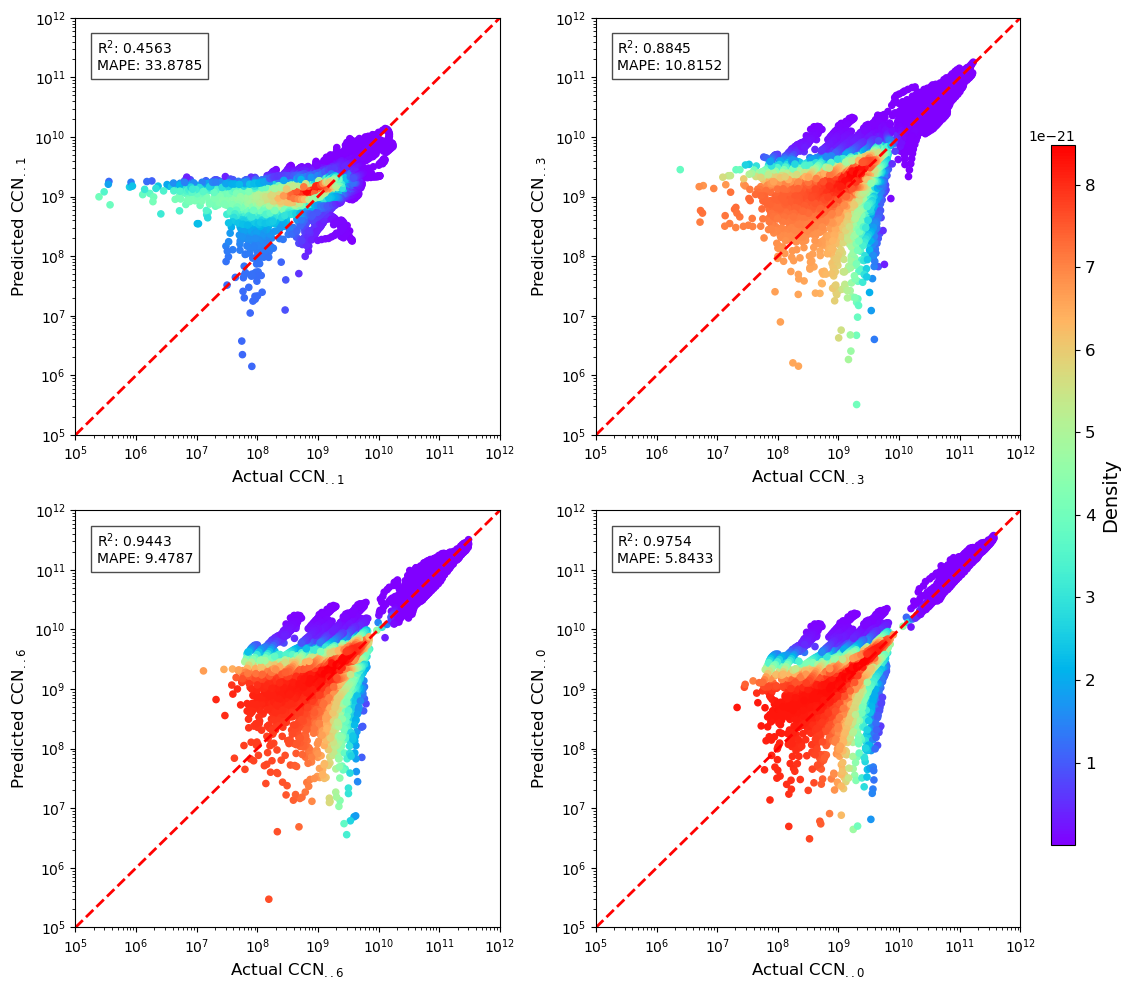

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, output in enumerate(output_list):
    X_train = train[input_list]
    y_train = train[output]
    X_test = test[input_list]
    y_test = test[output]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    # 可选：保存训练好的模型
    model_filename = f"/data/keeling/a/xx24/e/proj_ml/LinearRegression_emulator_ccn_{output[4:]}.pkl"
    joblib.dump(lin_reg, model_filename)
    
    # 在测试集上进行预测
    y_test_pred = lin_reg.predict(X_test)
    
    # 计算评价指标
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    print(f"{output} - MAPE: {mape:.4f}, R2: {r2:.4f}")
    
    # 根据输出变量名称设置图例标识
    if output[-2:] == '_1':
        var = f'CCN$_1$'
    else:    
        var = f'CCN$_{{{output[-2:-1]}.{output[-1:]}}}$'
    
    # 注意：这里为了与之前的绘图保持一致，将测试标签和预测值乘以 1e6
    scatter = calculate_metrics_and_plot(axes[i], y_test*1e6, y_test_pred*1e6, var)

# 调整图形布局并添加 colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()